In [15]:
# necessary packages
import glob
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset

### Noise models

For MODISA, the noise level for $L_T(\lambda)$ is estimated as $C_0(\lambda)+L_T(\lambda)C_1(\lambda)$, where $C_0$ and $C_1$ are empirically determined and stored in the src_l2gen_loadl1.c file. For SeaWiFS, I believe an older algorithm exists (or at least, the code appears to support this), but has been superceded by a polynomial model for SNR.

In [88]:
# get data
files = glob.glob('seawifs_unc_zach/L2_sub_seawifs_gyre/*.nc')

Rrs_wl = np.array([412,443,490,510,555,670])
Rrs = np.array([np.concatenate([Dataset(f).variables['Rrs_%03d'%wl][:].reshape(1,5,5) for f in files]) for wl in Rrs_wl])

Lt_wl = np.array([412,443,490,510,555,670,765,865])
Lt = np.array([np.concatenate([Dataset(f).variables['Lt_%03d'%wl][:].reshape(1,5,5) for f in files]) for wl in Lt_wl])
Lt /= 10 # suggestion by Lachlan that seems to be borne out considering the range of Lt should be 0.1--10 or sof

In [89]:
Lt_noise_linear = np.fliplr(np.array([[0.00088, 0.059],
        [0.00078, 0.05012],
        [0.00073, 0.03689],
        [0.00074, 0.03199],
        [0.0008, 0.05593],
        [0.00108, 0.04337],
        [0.00093, 0.0261],
        [0.00109, 0.02123]])) # flip this one because numpy polyval assumes Lt*C0 + C1, not C0 + C1*Lt
Lt_noise_poly = np.array([
        [-8.28726301e-03, 3.85425664e-01, -9.10776926e+00, 1.65881862e+02, 4.54351582e-01],
        [-1.21871258e-02, 5.21579320e-01, -1.14574109e+01, 1.96509056e+02, 4.18921861e-01],
        [-2.99068165e-02, 1.05225457e-00, -1.90591166e+01, 2.66343986e+02, 6.67187489e-01],
        [-5.68939986e-02, 1.67950509e-00, -2.56915149e+01, 3.05832773e+02, 9.34468454e-01],
        [-1.31635902e-01, 3.09617393e-00, -3.73473556e+01, 3.52394751e+02, 3.54105899e-01],
        [-8.65458303e-01, 1.18857306e+01, -8.37771886e+01, 4.64496430e+02, 4.14633422e-02],
        [-4.96827099e+00, 4.50239057e+01, -2.10425126e+02, 7.75862055e+02, 5.18893137e-02],
        [-1.30487418e+01, 9.35407901e+01, -3.40988182e+02, 9.43414239e+02, 7.84956550e-01]]) # this appears to be correct without need for flipping

In [90]:
Lt_covs = np.array([np.cov(Lt[:,i].reshape(len(Lt_wl),-1)) for i in range(len(files))])
median_Lt_covs = np.median(Lt_covs,axis=0)


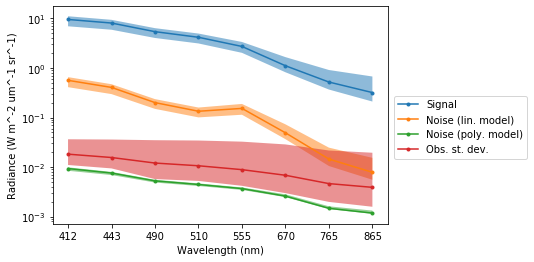

In [159]:
marker = '.'
CI = [5,95]
plt.plot(np.nanmedian(Lt,axis=(1,2,3)),marker=marker,label='Signal')
plt.fill_between(np.arange(len(Lt_wl)),*np.nanpercentile(Lt,CI,axis=(1,2,3)),alpha=0.5)
plt.plot(np.nanmedian(np.polyval(Lt_noise_linear.T,Lt.T).T,axis=(1,2,3)),marker=marker,label='Noise (lin. model)')
plt.fill_between(np.arange(len(Lt_wl)),*np.nanpercentile(np.polyval(Lt_noise_linear.T,Lt.T).T,CI,axis=(1,2,3)),alpha=0.5)
plt.plot(np.nanmedian(Lt/np.polyval(Lt_noise_poly.T,Lt.T).T,axis=(1,2,3)),marker=marker,label='Noise (poly. model)')
plt.fill_between(np.arange(len(Lt_wl)),*np.nanpercentile(Lt/np.polyval(Lt_noise_poly.T,Lt.T).T,CI,axis=(1,2,3)),alpha=0.5)
plt.plot(np.sqrt(np.diag(median_Lt_covs)),marker=marker,label='Obs. st. dev.')
plt.fill_between(np.arange(len(Lt_wl)),np.sqrt(np.diag(np.percentile(Lt_covs,CI[0],axis=0))),
                 np.sqrt(np.diag(np.percentile(Lt_covs,CI[1],axis=0))),alpha=0.5)
plt.ylabel('Radiance (%s)'%Dataset(files[0]).variables['Lt_412'].units)
plt.xlabel('Wavelength (nm)')
plt.yscale('log')
plt.legend(loc=(1.02,.3))
plt.xticks(np.arange(len(Lt_wl)));
plt.gca().set_xticklabels(Lt_wl);

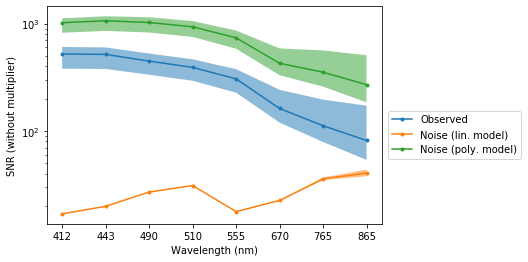

In [161]:
marker = '.'
CI = [5,95]
plt.plot(np.median((Lt.T/np.sqrt(np.diag(median_Lt_covs))).T,axis=(1,2,3)),marker=marker,label='Observed')
plt.fill_between(np.arange(len(Lt_wl)),*np.percentile((Lt.T/np.sqrt(np.diag(median_Lt_covs))).T,CI,axis=(1,2,3)),alpha=0.5)
plt.plot(np.nanmedian(Lt/np.polyval(Lt_noise_linear.T,Lt.T).T,axis=(1,2,3)),marker=marker,label='Noise (lin. model)')
plt.fill_between(np.arange(len(Lt_wl)),*np.nanpercentile(Lt/np.polyval(Lt_noise_linear.T,Lt.T).T,CI,axis=(1,2,3)),alpha=0.5)
plt.plot(np.nanmedian(np.polyval(Lt_noise_poly.T,Lt.T).T,axis=(1,2,3)),marker=marker,label='Noise (poly. model)')
plt.fill_between(np.arange(len(Lt_wl)),*np.nanpercentile(np.polyval(Lt_noise_poly.T,Lt.T).T,CI,axis=(1,2,3)),alpha=0.5)
plt.yscale('log')
plt.xlabel('Wavelength (nm)')
plt.ylabel('SNR (without multiplier)')
plt.yscale('log')
plt.legend(loc=(1.02,.3))
plt.xticks(np.arange(len(Lt_wl)));
plt.gca().set_xticklabels(Lt_wl);